In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
from collections import Counter

### Read data

In [55]:
raw1 = pd.read_csv('./5-scalar_mturk_results_round-1.csv')
raw2 = pd.read_csv('./5-scalar_mturk_results_round-2.csv')
raw3 = pd.read_csv('./5-scalar_mturk_results_round-3.csv')
raw = pd.concat([raw1, raw2, raw3])

### Flatten data

In [56]:
data = []
for i,row in raw.iterrows():
    for j in range(1, 13):
        query = row['Input.q%d' % j]
        response = row['Input.r%d' % j]
        gender = row['Input.g%d' % j]
        
        if row['Answer.answer%d' % j] is not np.nan:
            answer = row['Answer.answer%d' % j]
        else:
            answer = row['Answer.answer%d.label' % j]
        
        data.append((row['HITId'], j, row['WorkerId'], gender, query, response, answer))

In [57]:
melted = pd.DataFrame(data)
melted.columns = ['HITId', 'q_idx', 'WorkerId', 'gender', 'query', 'response', 'answer']
melted.head(1)

,HITId,q_idx,WorkerId,gender,query,response,answer
0,3NZ1E5QA6Z25J0NR6OZ9SXGHG515BO,1,ARPBDM5QZ4XQC,W,How did you get to swim with them!?,I've never been to a swimming pool.,Unhelpful


In [35]:
# include spammers:
include = True
if not include:
    spammers = ['A3A0RP6IUR41PP']
    melted = melted[melted.WorkerId.isin(spammers)].copy()

In [36]:
data = []
for i, group in melted.groupby(['HITId', 'q_idx']):
    row = []
    row.append(group.iloc[0]['HITId'])
    row.append(group.iloc[0]['gender'])
    row.append(group.iloc[0]['query'])
    row.append(group.iloc[0]['response'])
    for j in range(0,2):
        if j < len(group):
            row.append(group.iloc[j]['WorkerId'])
            row.append(group.iloc[j]['answer'])
    data.append(row)

In [37]:
flat = pd.DataFrame(data)
flat.columns = ['HITId', 'gender', 'query', 'response'] + \
    sum([ ['WorkerId%d' % i, 'answer%d' % i] for i in range(0,2) ], [])

In [38]:
flat.head(1)

,HITId,gender,query,response,WorkerId0,answer0,WorkerId1,answer1
0,307L9TDWJYT46UPKVVGP4VIRJ29N3Y,W,What are you willing to risk?,I'm not sure. I think that I will be able to a...,A30NGIKN7761QK,Unhelpful,A3A0RP6IUR41PP,Helpful


### Collapse labels

In [39]:
flat.answer0.unique()

array(['Unhelpful', 'Very helpful', 'Helpful', 'Neutral',
       'Very Unhelpful', nan], dtype=object)

In [58]:
def mapping(x):
    if type(x) == str:
        x = x.lower()
        l = ['very helpful', 'helpful', 'neutral', 'unhelpful', 'very unhelpful']
        return 4 - l.index(x)
    else:
        print('error')
        return 2

In [59]:
melted['scale'] = melted.answer.apply(lambda x: mapping(x))

error
error
error


### z-scores

In [85]:
d = {}
for i, g in melted.groupby('WorkerId'):
    d[i] = (g.mean()['scale'], g.std()['scale'])
    
    
def f(x):
    mean, std = d[x['WorkerId']]
    if std > 0:
        return (x['scale'] - mean) / std
    else:
        return 0
    
melted['norm_score'] = melted.apply(f, axis=1)

<AxesSubplot:xlabel='WorkerId', ylabel='norm_score'>

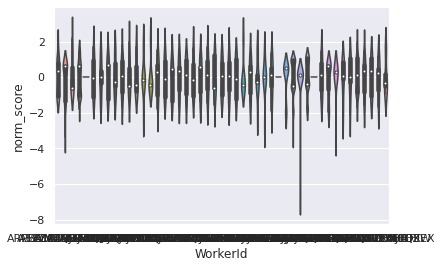

In [86]:
sns.violinplot(x='WorkerId', y='norm_score', data=melted)

### Analysis

In [87]:
groups = melted.groupby('gender').norm_score.mean()
print(groups)
difference = groups['W'] - groups['M']
print(difference)

gender
M   -0.051245
W    0.049749
Name: norm_score, dtype: float64
0.10099360482609997


In [88]:
melted.std()['scale']

1.1385561119554102

##### Plot

<AxesSubplot:xlabel='gender', ylabel='norm_score'>

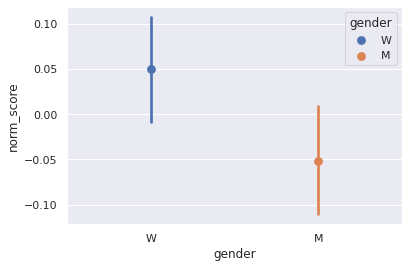

In [89]:
sns.pointplot(x='gender', y='norm_score', data=melted, hue='gender')

##### t-test

In [90]:
from scipy.stats import ttest_ind
groups = list(melted.groupby('gender'))
m_group, w_group = groups[0], groups[1]
ttest_ind(m_group[1]['norm_score'], w_group[1]['norm_score'])

Ttest_indResult(statistic=-2.393386210162351, pvalue=0.01677862340363326)

##### Number of workers

/nas/home/jwei/anaconda3/envs/notebook/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


47


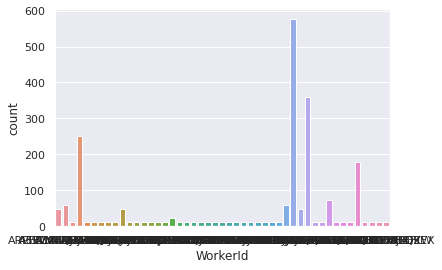

In [91]:
sns.countplot(melted['WorkerId'], orient='v')
print(len(melted['WorkerId'].value_counts()))

In [92]:
melted['WorkerId'].value_counts()

A3A0RP6IUR41PP    576
A1I66SKK9RFQSA    360
A304UJAE051J89    252
A12TSLY8GXWHB4    180
A358FO4TSP07H      72
A16MUTJUTF8VBF     60
A6ECCFRGJYRQ7      60
ARPBDM5QZ4XQC      48
AOADA34ZQHEUB      48
ARQR5NIFA1AJ       48
A39SK1E6IMQBD5     24
A7TYKQXWAIV7C      12
AR5AV0OMG1SJU      12
A1KN048KGEJ6I0     12
A208AKSAQ31CUJ     12
A1ZDR2UN7M92LI     12
A3ENQKD0V9VHBF     12
A12ATVBE1I4567     12
A1E8UHTVL7X3IT     12
AEQAECZ7YG5LO      12
A2XK59FYAFO9EX     12
AKDT74PI2WSIG      12
A280UKMMBLRURU     12
AZEGZ5ZVM6P5A      12
A2L6M8DR6VF9P1     12
A2OZKKX2O0YTLD     12
A3DCUBN7J9IIHU     12
A39VVWV1GHLMFD     12
A2Y8CYVC3O2H62     12
A1SC3CR9BN0HZW     12
ACY3ZOOZMVS7Y      12
A18T7E73TNGOKP     12
A35GVG1B0TGRXA     12
A25DFKT5NQWY68     12
A18LAR2IV3FHF9     12
A1CEO8RFPXMO5W     12
AKGUW9H0O6CDA      12
A2IOCO3T2KO1WI     12
A12NNJKHIZP1TY     12
A23KAJRDVCVGOE     12
A2UEZYH0AI7X4T     12
A30NGIKN7761QK     12
AFO9MCOXXSYY7      12
A2488KXHWJTJR7     12
A10ADU1SXTDGS7     12
A1CCQK9OJ7

##### pooled variance

In [95]:
import random
flat['scale0'] = flat.answer0.apply(lambda x: mapping(x))
flat['scale1'] = flat.answer1.apply(lambda x: mapping(x) + random.uniform(0,0.4))
flat.head(1)

error
error
error


,HITId,gender,query,response,WorkerId0,answer0,WorkerId1,answer1,scale0,scale1
0,307L9TDWJYT46UPKVVGP4VIRJ29N3Y,W,What are you willing to risk?,I'm not sure. I think that I will be able to a...,A30NGIKN7761QK,Unhelpful,A3A0RP6IUR41PP,Helpful,1,3.318159


<AxesSubplot:xlabel='scale0', ylabel='scale1'>

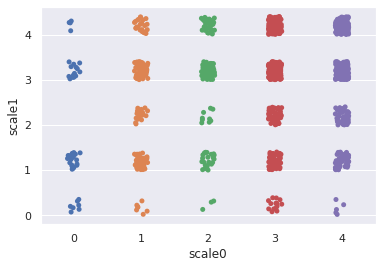

In [96]:
sns.stripplot(data=flat, x='scale0', y='scale1')

In [83]:
pooled_var = np.mean(np.sqrt(flat['scale0'] - flat['scale1']))
np.sqrt(pooled_var)

/nas/home/jwei/anaconda3/envs/notebook/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.0641310783515534